In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# read in training and test data
space_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print(f'Shape of data is {space_data.shape}')

Shape of data is (8693, 14)


# **Inspecting the Data**

In [3]:
# inspect data
space_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
space_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
space_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# **Plotting the Data**

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Axes: xlabel='Count', ylabel='Transported'>

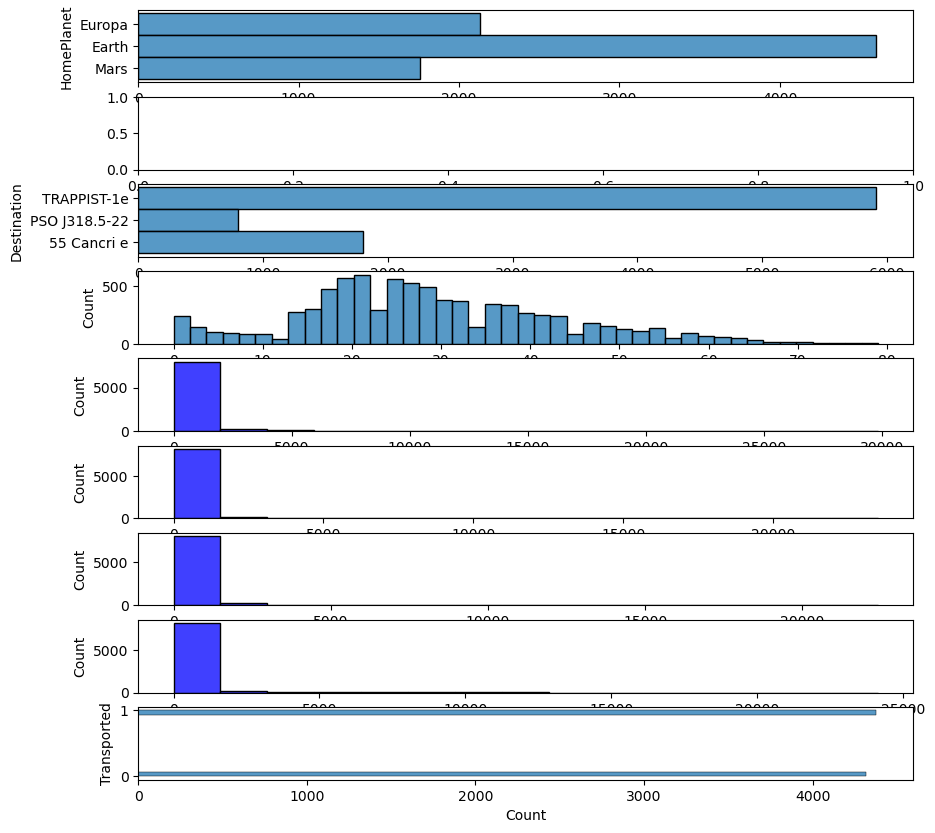

In [6]:
fig, ax = plt.subplots(9,1,  figsize=(10, 10))
sns.histplot(space_data, y='HomePlanet', ax=ax[0])
#sns.histplot(space_data, x='CryoSleep', ax=ax[1])
sns.histplot(space_data, y='Destination', ax=ax[2])
sns.histplot(space_data, x='Age', ax=ax[3])
sns.histplot(space_data, x='FoodCourt', color='b', bins=15, ax=ax[4])
sns.histplot(space_data, x='ShoppingMall', color='b', bins=15, ax=ax[5])
sns.histplot(space_data, x='Spa', color='b', bins=15, ax=ax[6])
sns.histplot(space_data, x='VRDeck', color='b', bins=15, ax=ax[7])
sns.histplot(space_data, y='Transported', ax=ax[8])

# **Preprocessing**

In [7]:
# ID and name not useful predictors
space_data = space_data.drop(['PassengerId', 'Name'], axis=1)
space_data.head()


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [8]:
# Find columns with null
space_data.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [9]:
y = space_data['Transported']

features = ['Age']
X = space_data[features]

print(X, y)

       Age
0     39.0
1     24.0
2     58.0
3     33.0
4     16.0
...    ...
8688  41.0
8689  18.0
8690  26.0
8691  32.0
8692  44.0

[8693 rows x 1 columns] 0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool


In [10]:
# Replace NaN with mean in Age column
age_mean = X['Age'].mean().round().astype(int)
X['Age'] = X['Age'].fillna(age_mean)

/tmp/ipykernel_20/4258254161.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'] = X['Age'].fillna(age_mean)


In [11]:
# Split training and validation data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

In [12]:
# Specify DecisionTreeRegressor model
DTR = DecisionTreeRegressor(random_state=0)

# Fit DecisionTreeRegressor model with data
DTR.fit(train_X, train_y)

DecisionTreeRegressor(random_state=0)